In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

In [5]:
# class Network(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(2, 4)
#         self.fc2 = nn.Linear(4, 10)
#         self.fc3 = nn.Linear(10, 1)

#     def forward(self,x):
#         x = torch.sigmoid(self.fc1(x))
#         x = torch.sigmoid(self.fc2(x))
#         x = torch.sigmoid(self.fc3(x))
#         return x
    
# model = Network()

# x = torch.randn([3,2], requires_grad=True)
# y = model(x)
# print(y.shape)
# print(y)


# # compute first order deriv
# dy_xy = torch.autograd.grad(y, x, torch.ones_like(y), 
#                             create_graph=True,
#                             retain_graph=True)[0]
# dy_x, dy_y = dy_xy.split(1,-1)
# # compute secord order deriv
# dy_x_xy = torch.autograd.grad(dy_x, x, torch.ones_like(dy_x), 
#                               create_graph=True,
#                               retain_graph=True)[0]
# dy_xx, dy_xy = dy_x_xy.split(1,-1)
# dy_y_xy = torch.autograd.grad(dy_y, x, torch.ones_like(dy_y),
#                               create_graph=True,
#                               retain_graph=True)[0]
# dy_yx, dy_yy = dy_y_xy.split(1,-1)

# # gather results in a matrix Bx2x2 in the form of Div-free kernel
# # K1 = torch.cat([-dy_yy, dy_xy], dim=-1)[...,None]
# # K2 = torch.cat([dy_yx, -dy_xx], dim=-1)[...,None]
# # K = torch.cat([K1, K2], dim=-1)
# # the columns of K make a divergence-free field
# u =  dy_xy - dy_yy
# v =  dy_xy - dy_xx

# # check if it is divergence free
# du_xy = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
# dv_xy = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
# # last two columns are x and y
# div_u_xy = du_xy[...,0] + dv_xy[...,1]


# print(du_xy[:3,:])
# print(dv_xy[:3,:])
# print(div_u_xy)

In [6]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.nout = 2
        self.fc1 = nn.Linear(2,  256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, self.nout)
        
    def forward_mlp(self,x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        return x

    def forward(self,xin):
        x = self.forward_mlp(xin)
#         x = self.divFree(xin)
        return x
    
    def compute_u_x(self, x):
#         self.u_x = torch.autograd.functional.jacobian(self, x, create_graph=True)
        # compute first order deriv
        x.requires_grad_(True)
        u = self.forward_mlp(x)
        assert x.shape[-1] == 2
        assert u.shape[-1] == 1
        self.u_x = torch.autograd.grad(u, x, torch.ones_like(u),
                                       create_graph=True, retain_graph=True)[0]
        return self.u_x
    
    def compute_u_xx(self, x):
        # compute 1st derivate
        u_x = self.compute_u_x(x)
        u_x, u_y = u_x.split(1,-1)
        
        # compute 2nd derivates
        u_x_x = torch.autograd.grad(u_x, x, torch.ones_like(u_x),
                                   create_graph=True, retain_graph=True)[0]
        self.u_xx, self.u_xy = u_x_x.split(1,-1)
        
        u_y_x = torch.autograd.grad(u_y, x, torch.ones_like(u_y),
                                   create_graph=True, retain_graph=True)[0]
        self.u_yx, self.u_yy = u_y_x.split(1,-1)
        
        # assert torch.allclose(self.u_yx, self.u_xy)
                
        return self.u_xx, self.u_xy, self.u_yx, self.u_yy
    
    def divFree(self, x):
        u_x = self.compute_u_x(x)
        u_xx, u_xy, _, u_yy = self.compute_u_xx(x)
        
        u = u_xy - u_xx
        v = u_xy - u_yy
        
        uv = torch.cat([u, v], dim=-1)    
        return uv
    
    def fit(self, trainloader, epochs=1000):
        self.train()
        optimiser = torch.optim.Adam(self.parameters(), lr=1e-4)
        epoch = 0
        while epoch < epochs or loss < 1e-6:
            epoch += 1
            current_loss = 0
            batches = 0
            progress = 0
            for x_batch, y_batch in trainloader:
                batches += 1
                optimiser.zero_grad()
                x_batch.requires_grad_(True)

                y_hat = self.forward(x_batch)
#                 # compute soft constraint
#                 u, v = torch.split(y_hat,1,-1)
#                 du_x = torch.autograd.grad(u, x_batch, torch.ones_like(u), create_graph=True)[0]       
#                 dv_y = torch.autograd.grad(v, x_batch, torch.ones_like(v), create_graph=True)[0]
#                 div_u = du_x[...,0] + dv_y[...,1]
#                 loss_pde = torch.norm(div_u)
                loss_rec = torch.nn.functional.mse_loss(y_hat, y_batch)
                loss = loss_rec

                current_loss += (1/batches) * (loss.item() - current_loss)


                loss.backward()
                optimiser.step()
                progress += y_batch.size(0)
                if epoch % 100 == 0:
#                     print('Epoch: %d, Loss: (%f + %f) = %f' % (epoch, loss_rec.item(), loss_pde.item(), current_loss))
                    print('Epoch: %d, Loss: %f' % (epoch, current_loss))
        print('Done with Training')
        print('Final error:', current_loss)

    
model = Network()

x = torch.randn([100,2], requires_grad=True)
y_hat = model(x)
print(y_hat[:2,:])

# u_x = model.compute_u_x(x)
# u_xx = model.compute_u_xx(x)

# uv = model.divFree(x)

tensor([[-0.1026, -0.1721],
        [ 0.1111,  0.0153]], grad_fn=<SliceBackward>)


In [7]:
xmin, xmax = (-1, 1)
ymin, ymax = (-1, 1)
N = 50

x = np.linspace(xmin, xmax, N)
y = np.linspace(ymin, ymax, N)

xx, yy = np.meshgrid(x,y)

my_df_fun = lambda a, b : np.array([b*a**2, -a*b**2])

F = my_df_fun(xx, yy)
print(F.shape)

(2, 50, 50)


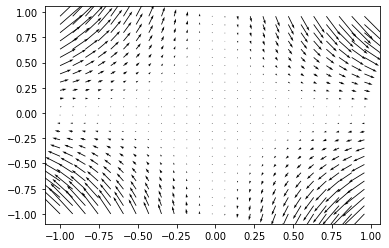

[0.04081632653061229, 0.04081632653061229]
(2, 50, 50)


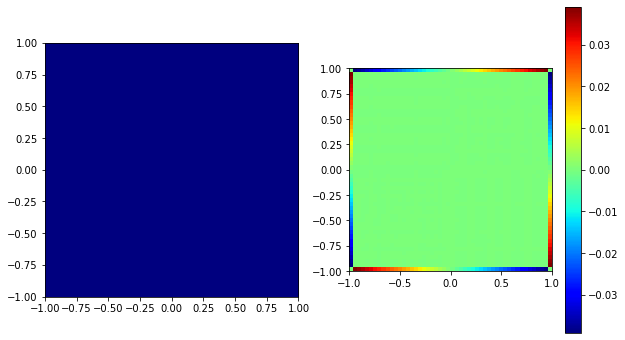

In [11]:
# plt.subplot(121)
# plt.imshow(uu)
# plt.subplot(122)
# plt.imshow(vv)
# plt.show()

ds = 2
plt.quiver(xx[::ds,::ds], yy[::ds,::ds], 
           F[0,::ds,::ds], F[1,::ds,::ds])
plt.show()

div_analy = 2*xx*yy - 2*xx*yy

def divergence(f, sp, indexing = "xy"):
    """ 
    Computes divergence of vector field 
    f: array -> vector field components [Fx,Fy,Fz,...]
    sp: array -> spacing between points in respecitve directions [spx, spy,spz,...]
    indexing: "xy" or "ij", see np.meshgrid indexing 

    """
    num_dims = len(f)
    
    if indexing == "xy":
        return np.ufunc.reduce(np.add, [np.gradient(f[num_dims - i - 1], sp[i], axis=i) for i in range(num_dims)])
    if indexing == "ij":
        return np.ufunc.reduce(np.add, [np.gradient(vectors[i], sp[i], axis=i) for i in range(num_dims)])
    
points = [x, y]
sp = [np.diff(p)[0] for p in points]
print(sp)
print(F.shape)
div_num = divergence(F, sp, indexing='xy')

plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(div_analy, extent=[xmin,xmax,ymin,ymax],  origin="lower", cmap="jet")
plt.subplot(122)
plt.imshow(div_num, extent=[xmin,xmax,ymin,ymax],  origin="lower", cmap="jet")
plt.colorbar()
plt.show()

In [14]:
from torch.utils.data import Dataset, DataLoader

X = np.concatenate([xx.flatten()[:,None], 
                    yy.flatten()[:,None]],axis=-1)
y = my_df_fun(X[:,0], X[:,1]).T

print(y.min(),'<= y <=',y.max())

class MyDataset(Dataset):
    
    def __init__(self, X, y, device):
        
        self.X = torch.from_numpy(X).float().to(device).view(-1,2)
        self.y = torch.from_numpy(y).float().to(device).view(-1,2)
        
        assert torch.all(torch.abs(self.y) <= 1)

        assert self.X.shape[0] == self.y.shape[0]

    
    def __len__(self):
        return self.X.shape[0]
    

    def __getitem__(self, idx):
        X = self.X[idx,:]
        y = self.y[idx,:]
        return (X, y)
    
torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

trainset = MyDataset(X, y, device=device)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

-1.0 <= y <= 1.0


In [15]:
model.to(device)
model.fit(trainloader,epochs=2000)

Epoch: 100, Loss: 0.013935
Epoch: 200, Loss: 0.003004
Epoch: 300, Loss: 0.002087
Epoch: 400, Loss: 0.001615
Epoch: 500, Loss: 0.001297
Epoch: 600, Loss: 0.001123
Epoch: 700, Loss: 0.000889
Epoch: 800, Loss: 0.000766
Epoch: 900, Loss: 0.000677
Epoch: 1000, Loss: 0.000614
Epoch: 1100, Loss: 0.000567
Epoch: 1200, Loss: 0.000527
Epoch: 1300, Loss: 0.000494
Epoch: 1400, Loss: 0.000466
Epoch: 1500, Loss: 0.000441
Epoch: 1600, Loss: 0.000421
Epoch: 1700, Loss: 0.000401
Epoch: 1800, Loss: 0.000393
Epoch: 1900, Loss: 0.000369
Epoch: 2000, Loss: 0.000778
Done with Training
Final error: 0.0007782901520840824


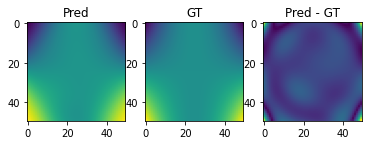

In [26]:
x = np.linspace(xmin, xmax, N)
y = np.linspace(ymin, ymax, N)
xx, yy = np.meshgrid(x,y)

X = np.concatenate([xx.flatten()[:,None], 
                    yy.flatten()[:,None]],axis=-1)

y_gt = my_df_fun(X[:,0],X[:,1]).T

X = torch.from_numpy(X).float().to(device)
y_hat = model(X).detach().cpu().numpy()

plt.subplot(131)
plt.imshow(y_hat[:,0].reshape(N,N))
plt.title('Pred')
plt.subplot(132)
plt.imshow(y_gt[:,0].reshape(N,N))
plt.title('GT')
plt.subplot(133)
plt.title('Pred - GT')
plt.imshow((np.abs(y_gt - y_hat))[:,0].reshape(N,N))

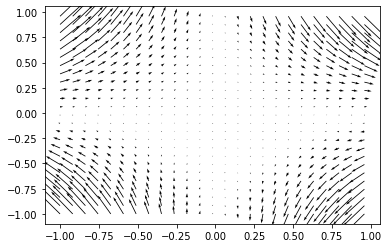

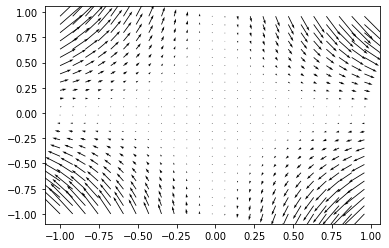

In [36]:
plt.quiver(xx[::ds,::ds], yy[::ds,::ds], 
           y_hat[:,0].reshape(N,N)[::ds,::ds], 
           y_hat[:,1].reshape(N,N)[::ds,::ds])
plt.show()
plt.quiver(xx[::ds,::ds], yy[::ds,::ds], 
           y_gt[:,0].reshape(N,N)[::ds,::ds], 
           y_gt[:,1].reshape(N,N)[::ds,::ds])
plt.show()

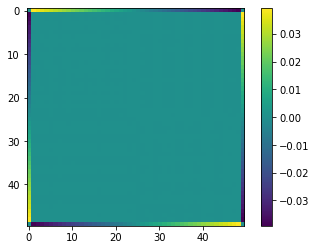

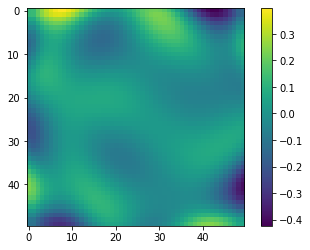

In [38]:
f_gt = y_gt.T.reshape(2,N,N)
div_num = divergence(f_gt, sp, indexing='xy')

plt.imshow(div_num)
plt.colorbar()
plt.show()

f_hat = y_hat.T.reshape(2,N,N)
div_num = divergence(f_hat, sp, indexing='xy')
plt.imshow(div_num)
plt.colorbar()
plt.show()

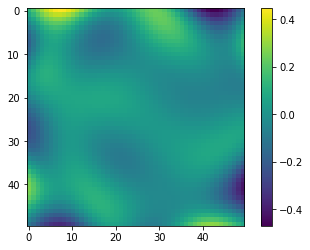

In [39]:
X.requires_grad_(True)
y = model(X)

u, v = y.split(1,-1)
du_xy = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
dv_xy = torch.autograd.grad(v, X, torch.ones_like(v), create_graph=True)[0]
# last two columns are x and y
div_u_xy = du_xy[...,0] + dv_xy[...,1]

plt.imshow(div_u_xy.detach().cpu().numpy().reshape(N,N))
plt.colorbar()

In [46]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.nout = 2
        self.fc1 = nn.Linear(2,  256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, self.nout)
        
    def forward_mlp(self,x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        return x

    def forward(self,xin):
        x = self.forward_mlp(xin)
        x = self.divFree(xin)
        return x
    
    def compute_u_x(self, x):
#         self.u_x = torch.autograd.functional.jacobian(self, x, create_graph=True)
        # compute first order deriv
        x.requires_grad_(True)
        u = self.forward_mlp(x)
        assert x.shape[-1] == 2
        assert u.shape[-1] == 1
        self.u_x = torch.autograd.grad(u, x, torch.ones_like(u),
                                       create_graph=True, retain_graph=True)[0]
        return self.u_x
    
    def compute_u_xx(self, x):
        # compute 1st derivate
        u_x = self.compute_u_x(x)
        u_x, u_y = u_x.split(1,-1)
        
        # compute 2nd derivates
        u_x_x = torch.autograd.grad(u_x, x, torch.ones_like(u_x),
                                   create_graph=True, retain_graph=True)[0]
        self.u_xx, self.u_xy = u_x_x.split(1,-1)
        
        u_y_x = torch.autograd.grad(u_y, x, torch.ones_like(u_y),
                                   create_graph=True, retain_graph=True)[0]
        self.u_yx, self.u_yy = u_y_x.split(1,-1)
        
        # assert torch.allclose(self.u_yx, self.u_xy)
                
        return self.u_xx, self.u_xy, self.u_yx, self.u_yy
    
    def divFree(self, x):
        u_x = self.compute_u_x(x)
        u_xx, u_xy, _, u_yy = self.compute_u_xx(x)
        
        u = u_xy - u_xx
        v = u_xy - u_yy
        
        uv = torch.cat([u, v], dim=-1)    
        return uv
    
    def fit(self, trainloader, epochs=1000):
        self.train()
        optimiser = torch.optim.Adam(self.parameters(), lr=1e-4)
        epoch = 0
        while epoch < epochs or loss < 1e-6:
            epoch += 1
            current_loss = 0
            batches = 0
            progress = 0
            for x_batch, y_batch in trainloader:
                batches += 1
                optimiser.zero_grad()
                x_batch.requires_grad_(True)

                y_hat = self.forward(x_batch)
#                 # compute soft constraint
#                 u, v = torch.split(y_hat,1,-1)
#                 du_x = torch.autograd.grad(u, x_batch, torch.ones_like(u), create_graph=True)[0]       
#                 dv_y = torch.autograd.grad(v, x_batch, torch.ones_like(v), create_graph=True)[0]
#                 div_u = du_x[...,0] + dv_y[...,1]
#                 loss_pde = torch.norm(div_u)
                loss_rec = torch.nn.functional.mse_loss(y_hat, y_batch)
                loss = loss_rec

                current_loss += (1/batches) * (loss.item() - current_loss)


                loss.backward()
                optimiser.step()
                progress += y_batch.size(0)
                if epoch % 100 == 0:
#                     print('Epoch: %d, Loss: (%f + %f) = %f' % (epoch, loss_rec.item(), loss_pde.item(), current_loss))
                    print('Epoch: %d, Loss: %f' % (epoch, current_loss))
        print('Done with Training')
        print('Final error:', current_loss)

In [48]:
model = Network().to(device)
model.to(device)
model.fit(trainloader,epochs=5000)

AssertionError: 

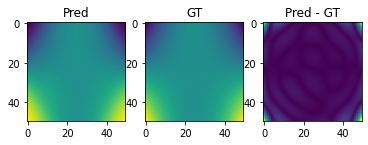

In [42]:
x = np.linspace(xmin, xmax, N)
y = np.linspace(ymin, ymax, N)
xx, yy = np.meshgrid(x,y)

X = np.concatenate([xx.flatten()[:,None], 
                    yy.flatten()[:,None]],axis=-1)

y_gt = my_df_fun(X[:,0],X[:,1]).T

X = torch.from_numpy(X).float().to(device)
y_hat = model(X).detach().cpu().numpy()

plt.subplot(131)
plt.imshow(y_hat[:,0].reshape(N,N))
plt.title('Pred')
plt.subplot(132)
plt.imshow(y_gt[:,0].reshape(N,N))
plt.title('GT')
plt.subplot(133)
plt.title('Pred - GT')
plt.imshow((np.abs(y_gt - y_hat))[:,0].reshape(N,N))

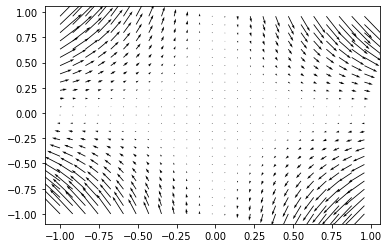

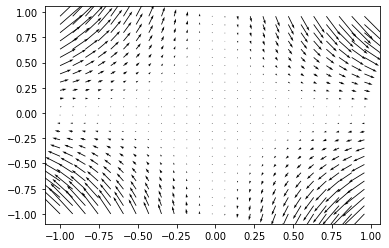

In [43]:
plt.quiver(xx[::ds,::ds], yy[::ds,::ds], 
           y_hat[:,0].reshape(N,N)[::ds,::ds], 
           y_hat[:,1].reshape(N,N)[::ds,::ds])
plt.show()
plt.quiver(xx[::ds,::ds], yy[::ds,::ds], 
           y_gt[:,0].reshape(N,N)[::ds,::ds], 
           y_gt[:,1].reshape(N,N)[::ds,::ds])
plt.show()

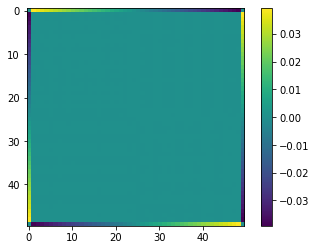

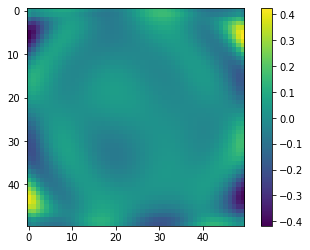

In [44]:
f_gt = y_gt.T.reshape(2,N,N)
div_num = divergence(f_gt, sp, indexing='xy')

plt.imshow(div_num)
plt.colorbar()
plt.show()

f_hat = y_hat.T.reshape(2,N,N)
div_num = divergence(f_hat, sp, indexing='xy')
plt.imshow(div_num)
plt.colorbar()
plt.show()

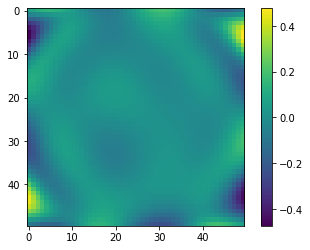

In [45]:
X.requires_grad_(True)
y = model(X)

u, v = y.split(1,-1)
du_xy = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
dv_xy = torch.autograd.grad(v, X, torch.ones_like(v), create_graph=True)[0]
# last two columns are x and y
div_u_xy = du_xy[...,0] + dv_xy[...,1]

plt.imshow(div_u_xy.detach().cpu().numpy().reshape(N,N))
plt.colorbar()

In [40]:
from turboflow.models.divfree_rff import DivFree

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = Network()
    
x = torch.randn(5,2).requires_grad_(True)
a = torch.randn(5,2)


y = model(x)
div = DivFree()
pred = div(y, x)

u, v = torch.split(pred,1,-1)
du_xy = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]       
dv_xy = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
# last two columns are x and y
div_u_xy = du_xy[:,0] + dv_xy[:,1]

print('Output dimension')
print(du_xy.shape)
print(dv_xy.shape)

print(du_xy)
print(dv_xy)
print(div_u_xy)

print('Output')
print(pred)

torch.Size([5, 1])
Output dimension
torch.Size([5, 2])
torch.Size([5, 2])
tensor([[-7.6681e-08, -1.8185e-07],
        [ 3.7526e-05,  4.0189e-05],
        [-8.8986e-05, -7.0605e-05],
        [-1.3843e-04, -1.1057e-04],
        [-6.2141e-04, -2.4820e-04]], grad_fn=<MmBackward>)
tensor([[ 3.2334e-08,  7.6681e-08],
        [-3.5040e-05, -3.7526e-05],
        [ 1.1215e-04,  8.8987e-05],
        [ 1.7331e-04,  1.3843e-04],
        [ 1.5558e-03,  6.2141e-04]], grad_fn=<MmBackward>)
tensor([ 2.1316e-13,  2.1828e-11,  3.6380e-11,  5.8208e-11, -5.2387e-10],
       grad_fn=<AddBackward0>)
Output
tensor([[-2.7997e-06,  1.1806e-06],
        [-1.6292e-04,  1.5213e-04],
        [ 2.6432e-04, -3.3313e-04],
        [ 4.0475e-04, -5.0672e-04],
        [ 3.7424e-04, -9.3697e-04]], grad_fn=<TanhBackward>)


In [3]:
from turboflow.dataloaders import Turbo2D_simple
from torch.utils.data import Dataset, DataLoader


use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, ds=4, img=42)
trainloader = DataLoader(trainset, batch_size=10000, shuffle=False)

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0


In [18]:
from turboflow.models.phyrff_hard import DivFreeRFFNet
dfrff = DivFreeRFFNet('DivFree', [2*256] + 3*[128] + [1], 256, 10)
print(dfrff)
x = torch.randn(3,2)

pred = dfrff(x)
print(pred)

u, v = torch.split(pred,1,-1)
du_xy = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]       
dv_xy = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
# last two columns are x and y
div_u_xy = du_xy[...,0] + dv_xy[...,1]
print(du_xy[:,0])
print(dv_xy[:,1])
print(div_u_xy)

DivFreeRFFNet(
  (mlp): MLP(
    (rff): Fourier()
    (mlp): Sequential(
      (0): Sequential(
        (0): Linear(in_features=512, out_features=128, bias=True)
        (1): Tanh()
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Tanh()
      )
      (2): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Tanh()
      )
      (3): Sequential(
        (0): Linear(in_features=128, out_features=1, bias=True)
        (1): Sigmoid()
      )
    )
  )
)
tensor([[ 0.6477,  1.0578],
        [ 1.2798,  0.2416],
        [-0.7426,  0.5999]], grad_fn=<CatBackward>)
tensor([   4.8070, -200.9207,   55.6096], grad_fn=<SelectBackward>)
tensor([ -4.8070, 200.9207, -55.6096], grad_fn=<SelectBackward>)
tensor([-6.6757e-06, -3.0518e-05,  1.5259e-05], grad_fn=<AddBackward0>)


In [19]:
dfrff.to(device)
dfrff.fit(trainloader, epochs=2000)

Epoch: 100, Loss: (rec: [0.044691] + 1.00 * div-free: [0.000000]) = 0.044691
Epoch: 200, Loss: (rec: [0.033236] + 1.00 * div-free: [0.000000]) = 0.033236
Epoch: 300, Loss: (rec: [0.025179] + 1.00 * div-free: [0.000000]) = 0.025179
Epoch: 400, Loss: (rec: [0.017306] + 1.00 * div-free: [0.000000]) = 0.017306
Epoch: 500, Loss: (rec: [0.009951] + 1.00 * div-free: [0.000000]) = 0.009951
Epoch: 600, Loss: (rec: [0.005364] + 1.00 * div-free: [0.000000]) = 0.005364
Epoch: 700, Loss: (rec: [0.003156] + 1.00 * div-free: [0.000000]) = 0.003156
Epoch: 800, Loss: (rec: [0.001967] + 1.00 * div-free: [0.000000]) = 0.001967
Epoch: 900, Loss: (rec: [0.001233] + 1.00 * div-free: [0.000000]) = 0.001233
Epoch: 1000, Loss: (rec: [0.000765] + 1.00 * div-free: [0.000000]) = 0.000766
Epoch: 1100, Loss: (rec: [0.000472] + 1.00 * div-free: [0.000001]) = 0.000473
Epoch: 1200, Loss: (rec: [0.000292] + 1.00 * div-free: [0.000001]) = 0.000292
Epoch: 1300, Loss: (rec: [0.000181] + 1.00 * div-free: [0.000001]) = 0.00

(16384, 2)
tensor([ -6.8840,  -8.1899,  16.5781,  ..., -31.9304, -20.7562,  20.6846],
       device='cuda:0', grad_fn=<SelectBackward>)
tensor([  6.8840,   8.1899, -16.5781,  ...,  31.9304,  20.7562, -20.6846],
       device='cuda:0', grad_fn=<SelectBackward>)
tensor([-3.8147e-06, -1.7166e-05, -1.7166e-05,  ..., -7.6294e-06,
        -9.5367e-06, -2.0981e-05], device='cuda:0', grad_fn=<AddBackward0>)


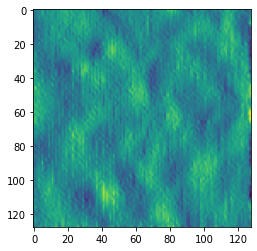

In [20]:
# TEST
import numpy as np
import matplotlib.pyplot as plt

ngrid = 128
coords = np.linspace(0, 1, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)

dfrff.eval().to(device)
pred = dfrff(x)

ypred = pred.cpu().detach().numpy().squeeze()

u, v = torch.split(pred,1,-1)
du_xy = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]       
dv_xy = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
# last two columns are x and y
div_u_xy = du_xy[...,0] + dv_xy[...,1]
print(du_xy[:,0])
print(dv_xy[:,1])
print(div_u_xy)

plt.imshow(ypred.reshape(ngrid,ngrid,2)[:,:,0])
plt.show()

In [ ]:
c = dfrff.rbf.centers.detach().cpu().numpy()

plt.scatter(c[:,0],c[:,1])